In [1]:
# ═══════════════════════════════════════════════════════════════════════════
# 🏥 3-Stage Fine-tuning Lingshu-7B با IU X-ray Dataset - FINAL FIX
# ═══════════════════════════════════════════════════════════════════════════

import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
os.environ["TORCH_ALLOW_TF32_CUBLAS_OVERRIDE"] = "1"

print("📦 Installing packages...")
!pip install -q transformers>=4.49.0 accelerate bitsandbytes peft qwen-vl-utils datasets
!pip install -q pillow torchvision tqdm scikit-learn matplotlib

import gc, json, time, warnings, io
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from datasets import load_dataset
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import bitsandbytes as bnb 

from transformers import (
    AutoModelForVision2Seq,
    AutoProcessor,
    BitsAndBytesConfig,
)
from peft import (
    LoraConfig,
    get_peft_model,
    prepare_model_for_kbit_training,
)
from qwen_vl_utils import process_vision_info

warnings.filterwarnings('ignore')
torch.manual_seed(42)
np.random.seed(42)

# Helper Functions
def clear_memory():
    gc.collect()
    torch.cuda.empty_cache()
    if torch.cuda.is_available(): torch.cuda.synchronize()

def set_training_stage(model, stage):
    print(f"\n⚙️ Configuring model for STAGE {stage}...")
    for param in model.parameters(): param.requires_grad = False

    count_toggled = 0
    for name, param in model.named_parameters():
        if not param.is_floating_point(): continue
        
        # تشخیص لایه ها برای Qwen2.5-VL
        is_merger = "merger" in name or "projector" in name or "adapter" in name
        is_vision = "visual" in name and not is_merger
        is_llm = not (is_vision or is_merger)
        
        should_train = False
        if stage == 1 and is_vision: should_train = True
        elif stage == 2 and is_merger: should_train = True
        elif stage == 3 and is_llm: should_train = True
            
        if should_train:
            param.requires_grad = True
            if param.dtype != torch.float32: param.data = param.data.to(torch.float32)
            count_toggled += 1

    print(f"⚡ Stage {stage}: {count_toggled:,} params set to trainable.")
    return count_toggled

def train_stage(model, train_loader, stage_num, stage_name, epochs, lr=1e-4):
    print(f"\n{'='*70}\n🚀 STAGE {stage_num}: {stage_name.upper()}\n{'='*70}")
    clear_memory()
    if set_training_stage(model, stage_num) == 0: return
    
    trainable_params = [p for p in model.parameters() if p.requires_grad]
    optimizer = bnb.optim.PagedAdamW8bit(trainable_params, lr=lr)
    model.train()
    accumulation_steps = 4
    
    for epoch in range(epochs):
        total_loss = 0
        num_batches = 0
        optimizer.zero_grad()
        pbar = tqdm(train_loader, desc=f"Stage {stage_num} | Epoch {epoch+1}/{epochs}")
        
        for step, batch in enumerate(pbar):
            try:
                batch = {k: v.to(model.device) if isinstance(v, torch.Tensor) else v for k, v in batch.items()}
                with torch.amp.autocast('cuda', dtype=torch.float16):
                    outputs = model(**batch)
                    loss = outputs.loss / accumulation_steps
                loss.backward()
                
                if (step + 1) % accumulation_steps == 0:
                    torch.nn.utils.clip_grad_norm_(trainable_params, max_norm=1.0)
                    optimizer.step()
                    optimizer.zero_grad()
                
                current_loss = loss.item() * accumulation_steps
                total_loss += current_loss
                num_batches += 1
                pbar.set_postfix({'loss': f"{current_loss:.4f}", 'avg': f"{total_loss/num_batches:.4f}"})
                del outputs, loss
                if step % 10 == 0: clear_memory()
            except RuntimeError as e:
                if "out of memory" in str(e):
                    print(f"⚠️ OOM at step {step}"); clear_memory(); optimizer.zero_grad()
                else: break
        print(f"✅ Stage {stage_num} Epoch {epoch+1} Complete.")

# ═══════════════════════════════════════════════════════════════════════════
# DATASET FIX (Critical Update)
# ═══════════════════════════════════════════════════════════════════════════

print("\n📥 Loading Dataset...")
dataset = load_dataset("ykumards/open-i", split="train", trust_remote_code=True)

class IUXrayDataset(Dataset):
    def __init__(self, hf_dataset, num_samples=None):
        self.samples = []
        if num_samples:
            hf_dataset = hf_dataset.select(range(min(num_samples, len(hf_dataset))))
        
        print(f"\n🎨 Processing {len(hf_dataset)} X-ray samples...")
        print(f"📊 Columns found: {hf_dataset.column_names}")
        
        valid_count = 0
        skipped_count = 0
        
        # اولویت جستجو: اول img_frontal که دقیق است، بعد بقیه
        possible_keys = ['img_frontal', 'image', 'images', 'frontal_image']
        
        for idx in tqdm(range(len(hf_dataset)), desc="Processing"):
            try:
                item = hf_dataset[idx]
                
                # 1. پیدا کردن دیتای تصویر
                image_data = None
                found_key = "None"
                
                for key in possible_keys:
                    if key in item and item[key] is not None:
                        val = item[key]
                        # اگر لیست خالی نبود
                        if isinstance(val, list):
                            if len(val) > 0:
                                image_data = val[0]
                                found_key = key
                                break
                        else:
                            image_data = val
                            found_key = key
                            break
                
                if image_data is None:
                    skipped_count += 1
                    continue
                
                # 2. تبدیل به PIL Image
                img = None
                try:
                    # اگر خودش عکس PIL است
                    if isinstance(image_data, Image.Image):
                        img = image_data
                    # اگر بایت است
                    elif isinstance(image_data, bytes):
                        img = Image.open(io.BytesIO(image_data)).convert('RGB')
                    # اگر دیکشنری است (مثل {'bytes': ...})
                    elif isinstance(image_data, dict) and 'bytes' in image_data:
                        img = Image.open(io.BytesIO(image_data['bytes'])).convert('RGB')
                    # اگر مسیر فایل است (خیلی نادر در HF streaming)
                    elif isinstance(image_data, str) and os.path.exists(image_data):
                        img = Image.open(image_data).convert('RGB')
                    
                except Exception as img_err:
                    if idx < 3: print(f"⚠️ Image Convert Error (idx={idx}, key={found_key}): {img_err}")
                
                if img is None:
                    skipped_count += 1
                    if idx < 3: # فقط ۳ خطای اول را چاپ کن تا لاگ شلوغ نشود
                        print(f"⚠️ Skipped {idx}: Could not convert data type {type(image_data)} from key '{found_key}'")
                    continue
                
                # ریسایز
                img = img.resize((512, 512), Image.Resampling.LANCZOS)
                
                # ساخت متن گزارش
                findings = item.get('findings', '') or ''
                impression = item.get('impression', '') or ''
                if not findings and not impression:
                    # fallback به ستون‌های دیگر
                    report = item.get('caption', '') or item.get('text', 'No report available.')
                else:
                    report = f"FINDINGS: {findings}\nIMPRESSION: {impression}"
                
                self.samples.append({'image': img, 'text': report[:1500], 'uid': idx})
                valid_count += 1
                
            except Exception as e:
                skipped_count += 1
                if idx < 3: print(f"❌ Unknown Error at idx {idx}: {e}")
                continue
        
        print(f"✅ Samples Ready: {valid_count} (Skipped: {skipped_count})")
        if valid_count == 0:
            raise ValueError("No valid samples found! Check the debug logs above.")

    def __len__(self): return len(self.samples)
    def __getitem__(self, idx): return self.samples[idx]

class VLMCollator:
    def __init__(self, processor): self.processor = processor
    def __call__(self, batch):
        messages_list = []
        for item in batch:
            msg = [
                {"role": "user", "content": [{"type": "image", "image": item['image']}, {"type": "text", "text": "Generate radiology report."}]},
                {"role": "assistant", "content": [{"type": "text", "text": item['text']}]}
            ]
            messages_list.append(msg)
            
        texts = [self.processor.apply_chat_template(m, tokenize=False, add_generation_prompt=False) for m in messages_list]
        image_inputs = []
        for m in messages_list:
            imgs, _ = process_vision_info(m)
            image_inputs.extend(imgs)
            
        inputs = self.processor(
            text=texts, images=image_inputs, padding=True, truncation=True, max_length=1024, return_tensors='pt'
        )
        inputs['labels'] = inputs['input_ids'].clone()
        inputs['labels'][inputs['labels'] == self.processor.tokenizer.pad_token_id] = -100
        return inputs

# ═══════════════════════════════════════════════════════════════════════════
# EXECUTION
# ═══════════════════════════════════════════════════════════════════════════

MODEL_NAME = "lingshu-medical-mllm/Lingshu-7B"
processor = AutoProcessor.from_pretrained(MODEL_NAME, trust_remote_code=True)
model = AutoModelForVision2Seq.from_pretrained(
    MODEL_NAME,
    quantization_config=BitsAndBytesConfig(load_in_4bit=True, bnb_4bit_quant_type="nf4", bnb_4bit_compute_dtype=torch.float16),
    device_map="auto", trust_remote_code=True
)
model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)
model = get_peft_model(model, LoraConfig(r=16, lora_alpha=32, target_modules="all-linear", lora_dropout=0.05, bias="none", task_type="CAUSAL_LM"))

print("\n🚦 Prepare Dataset...")
train_dataset = IUXrayDataset(dataset, num_samples=50)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, collate_fn=VLMCollator(processor))

train_stage(model, train_loader, 1, "Vision Encoder", epochs=1)
train_stage(model, train_loader, 2, "Projector", epochs=1)
train_stage(model, train_loader, 3, "Language Model", epochs=1)

print("🎉 DONE!")

📦 Installing packages...
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
pylibcudf-cu12 25.2.2 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 22.0.0 which is incompatible.
cudf-cu12 25.2.2 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 22.0.0 which is incompatible.
bigframes 2.12.0 requires rich<14,>=12.4.4, but you have rich 14.2.0 which is incompatible.
libcugraph-cu12 25.6.0 requires libraft-cu12==25.6.*, but you have libraft-cu12 25.2.0 which is incompatible.
cudf-polars-cu12 25.6.0 requires pylibcudf-cu12==25.6.*, but you have pylibcudf-cu12 25.2.2 which is incompatible.
pylibcugraph-cu12 25.6.0 requires pylibraft-cu12==25.6.*, but you have pylibraft-cu12 25.2.0 which is incompatible

2025-12-16 21:37:12.787420: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765921033.179698      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765921033.298345      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

`trust_remote_code` is not supported anymore.
Please check that the Hugging Face dataset 'ykumards/open-i' isn't based on a loading script and remove `trust_remote_code`.
If the dataset is based on a loading script, please ask the dataset author to remove it and convert it to a standard format like Parquet.
ERROR:datasets.load:`trust_remote_code` is not supported anymore.
Please check that the Hugging Face dataset 'ykumards/open-i' isn't based on a loading script and remove `trust_remote_code`.
If the dataset is based on a loading script, please ask the dataset author to remove it and convert it to a standard format like Parquet.



📥 Loading Dataset...


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00005-c80629f6027d8e(…):   0%|          | 0.00/425M [00:00<?, ?B/s]

data/train-00001-of-00005-07e6c158a3f561(…):   0%|          | 0.00/418M [00:00<?, ?B/s]

data/train-00002-of-00005-653f05c8b15c22(…):   0%|          | 0.00/416M [00:00<?, ?B/s]

data/train-00003-of-00005-1d66a487a8489b(…):   0%|          | 0.00/416M [00:00<?, ?B/s]

data/train-00004-of-00005-208b7d689f1c7b(…):   0%|          | 0.00/421M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/3851 [00:00<?, ? examples/s]

preprocessor_config.json:   0%|          | 0.00/575 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/605 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/613 [00:00<?, ?B/s]

You have video processor config saved in `preprocessor.json` file which is deprecated. Video processor configs should be saved in their own `video_preprocessor.json` file. You can rename the file or load and save the processor back which renames it automatically. Loading from `preprocessor.json` will be removed in v5.0.


chat_template.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.69G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.93G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/244 [00:00<?, ?B/s]


🚦 Prepare Dataset...

🎨 Processing 50 X-ray samples...
📊 Columns found: ['uid', 'MeSH', 'Problems', 'image', 'indication', 'comparison', 'findings', 'impression', 'img_frontal', 'img_lateral']


Processing:   0%|          | 0/50 [00:00<?, ?it/s]

✅ Samples Ready: 50 (Skipped: 0)

🚀 STAGE 1: VISION ENCODER

⚙️ Configuring model for STAGE 1...
⚡ Stage 1: 545 params set to trainable.


Stage 1 | Epoch 1/1:   0%|          | 0/50 [00:00<?, ?it/s]

`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


✅ Stage 1 Epoch 1 Complete.

🚀 STAGE 2: PROJECTOR

⚙️ Configuring model for STAGE 2...
⚡ Stage 2: 7 params set to trainable.


Stage 2 | Epoch 1/1:   0%|          | 0/50 [00:00<?, ?it/s]

✅ Stage 2 Epoch 1 Complete.

🚀 STAGE 3: LANGUAGE MODEL

⚙️ Configuring model for STAGE 3...
⚡ Stage 3: 535 params set to trainable.


Stage 3 | Epoch 1/1:   0%|          | 0/50 [00:00<?, ?it/s]

✅ Stage 3 Epoch 1 Complete.
🎉 DONE!


In [3]:
import random


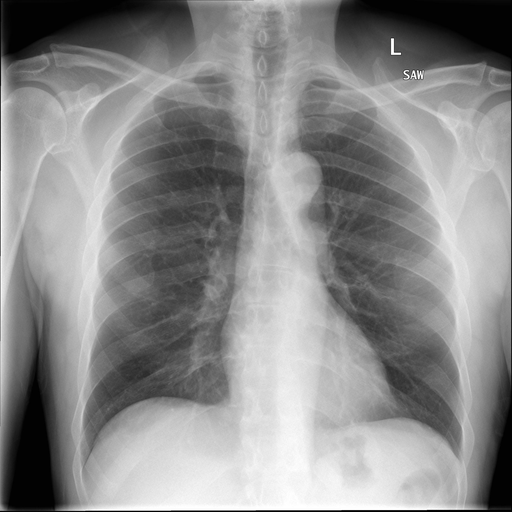

In [9]:
# ═══════════════════════════════════════════════════════════════════════════
# 💎 BEAUTIFUL INFERENCE UI
# ═══════════════════════════════════════════════════════════════════════════

from IPython.display import display, HTML
import base64
from io import BytesIO

def image_to_base64(img):
    """تبدیل تصویر به فرمت قابل نمایش در HTML"""
    buffered = BytesIO()
    img.save(buffered, format="PNG")
    return base64.b64encode(buffered.getvalue()).decode("utf-8")

def predict_beautiful(index=None):
    # 1. انتخاب و پیش‌بینی (مشابه قبل)
    if index is None: index = random.randint(0, len(train_dataset) - 1)
    
    sample = train_dataset[index]
    image = sample['image']
    img_str = image_to_base64(image)
    ground_truth = sample['text'].replace("\n", "<br>")
    
    # تولید
    messages = [{"role": "user", "content": [{"type": "image", "image": image}, {"type": "text", "text": "Analyze this chest X-ray and provide a detailed radiology report."}]}]
    text = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    image_inputs, _ = process_vision_info(messages)
    inputs = processor(text=[text], images=image_inputs, padding=True, return_tensors="pt").to(model.device)
    
    model.eval()
    with torch.no_grad():
        generated_ids = model.generate(**inputs, max_new_tokens=400, temperature=0.4, top_p=0.9)
    
    generated_ids_trimmed = [out_ids[len(in_ids):] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)]
    ai_report = processor.batch_decode(generated_ids_trimmed, skip_special_tokens=True)[0].replace("\n", "<br>")

    # 2. طراحی قالب HTML (Medical Dashboard Style)
    html_content = f"""
    <style>
        .container {{ font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif; max-width: 900px; margin: 0 auto; background: #fdfdfd; border-radius: 12px; box-shadow: 0 4px 20px rgba(0,0,0,0.1); overflow: hidden; border: 1px solid #e0e0e0; }}
        .header {{ background: linear-gradient(135deg, #2b5876 0%, #4e4376 100%); color: white; padding: 20px; text-align: center; }}
        .header h2 {{ margin: 0; font-weight: 600; font-size: 24px; }}
        .header p {{ margin: 5px 0 0; opacity: 0.8; font-size: 14px; }}
        .content {{ display: flex; flex-wrap: wrap; padding: 20px; gap: 20px; }}
        .image-box {{ flex: 1; min-width: 300px; display: flex; flex-direction: column; align-items: center; justify-content: start; }}
        .xray-img {{ max-width: 100%; border-radius: 8px; border: 3px solid #eef2f5; box-shadow: 0 2px 8px rgba(0,0,0,0.1); transition: transform 0.3s; }}
        .xray-img:hover {{ transform: scale(1.02); }}
        .reports-box {{ flex: 1.5; min-width: 300px; display: flex; flex-direction: column; gap: 20px; }}
        .card {{ background: white; border-radius: 8px; padding: 15px; border-left: 5px solid #ccc; box-shadow: 0 2px 5px rgba(0,0,0,0.05); }}
        .card-title {{ font-weight: bold; font-size: 14px; margin-bottom: 10px; display: flex; align-items: center; gap: 8px; }}
        .badge {{ padding: 3px 8px; border-radius: 4px; font-size: 11px; text-transform: uppercase; letter-spacing: 0.5px; color: white; }}
        
        .real-card {{ border-left-color: #28a745; background-color: #f9fff9; }}
        .real-badge {{ background-color: #28a745; }}
        
        .ai-card {{ border-left-color: #6c5ce7; background-color: #fcfcff; }}
        .ai-badge {{ background-color: #6c5ce7; }}
        
        .report-text {{ font-size: 13px; line-height: 1.6; color: #444; text-align: justify; }}
        strong {{ color: #222; }}
    </style>

    <div class="container">
        <div class="header">
            <h2>🩻 AI Radiology Assistant</h2>
            <p>Lingshu-7B • Intelligent X-Ray Analysis</p>
        </div>
        
        <div class="content">
            <!-- Left: Image -->
            <div class="image-box">
                <img src="data:image/png;base64,{img_str}" class="xray-img" alt="X-Ray">
                <div style="margin-top: 10px; color: #888; font-size: 12px;">Sample UID: {sample['uid']}</div>
            </div>
            
            <!-- Right: Reports -->
            <div class="reports-box">
                
                <!-- AI Report -->
                <div class="card ai-card">
                    <div class="card-title">
                        <span class="badge ai-badge">🤖 AI Analysis</span>
                        <span>Generated by Model</span>
                    </div>
                    <div class="report-text">{ai_report}</div>
                </div>

                <!-- Real Report -->
                <div class="card real-card">
                    <div class="card-title">
                        <span class="badge real-badge">👨‍⚕️ Ground Truth</span>
                        <span>Radiologist Report</span>
                    </div>
                    <div class="report-text">{ground_truth}</div>
                </div>
                
            </div>
        </div>
    </div>
    """
    display(HTML(html_content))

# اجرا کن! 😍
predict_beautiful()